In [2]:
# from github temp.jl, converted to python

# this section is about incorporating temperature dependence


import numpy as np
from numpy.random import default_rng
from scipy.stats import multivariate_normal

rng = default_rng(111) # random number generator


# note that the u(T) and m(T) equation have the same structure, except the parameters are different.
# both of the equations involve parameters like:
# B0 (base rate), E (activation energy), k (Boltzmann constant), Ed (deactivation energy), Tp (peak performance temperature), and Tr (reference temperature)
# first, we want to generate random parameters for each consumer (as mentioned above), like B, E, Tp
# and for each of these temp-dependent parameters, we want to generate one for uptake u(T) and one for respiration m(T)
# they're not actually fully random, as we do define mean and variance for teh parameters, and draw from a multivariate normal distribution



def randtemp_param(N, kw):
    """
    Generate random temperature-dependent trait parameters for consumers.

    Returns:
        B: base rates (N x 2)
        E: activation energies (N x 2)
        Tp: peak temperatures (N x 2)
    """
    L = kw['L'] # leakage
    rho_t = kw['rho_t']

    L_v = np.mean(L)
    B0_m = -1.4954 # I think this is mortality / respiration rate
    B0_CUE = 0.1953
    B0_u = np.log(np.exp(B0_m) / (1 - L_v - B0_CUE)) # I think this is uptake rate. dependent on carbon use efficiency (CUE) and leakage rate

    B0 = np.array([B0_u, B0_m]) # B0 is a vector of base rates for uptake and respiration
    B0_var = 0.17 * np.abs(B0) # variance of base rates, 0.17 is a scaling factor
    E_mean = np.array([0.8146, 0.5741]) # mean activation energies for uptake and respiration
    E_var = 0.1364 * E_mean # variance of activation energies, 0.1364 is a scaling factor
    cov_xy = rho_t * np.sqrt(B0_var * E_var) # covariance between base rates and activation energies, rho_t is the correlation coefficient

    cov_u = np.array([[B0_var[0], cov_xy[0]], [cov_xy[0], E_var[0]]]) # covariance matrix for uptake
    cov_m = np.array([[B0_var[1], cov_xy[1]], [cov_xy[1], E_var[1]]]) # covariance matrix for respiration

    allu = multivariate_normal.rvs(mean=[B0[0], E_mean[0]], cov=cov_u, size=N).T # draw random samples from multivariate normal distribution for uptake
    allm = multivariate_normal.rvs(mean=[B0[1], E_mean[1]], cov=cov_m, size=N).T # draw random samples from multivariate normal distribution for respiration

    B = np.column_stack((np.exp(allu[0]), np.exp(allm[0]))) # exponentiate the base rates to get the actual values
    E = np.column_stack((allu[1], allm[1])) # activation energies are already in the correct form

    Tpu = 273.15 + rng.normal(35, 5, N) # draw random peak temperatures for uptake from a normal distribution with mean 35 and std 5
    Tpm = Tpu + 3 # peak temperature for respiration is 3 degrees higher than for uptake
    Tp = np.column_stack((Tpu, Tpm)) # combine the peak temperatures into a single array

    return B, E, Tp


# randtemp_param_test = randtemp_param(3, {'L': 0.4, 'rho_t': -0.75})
# print(randtemp_param_test)
# this works - produces 2D arrays


# now we have generated parameters (generating B, E, Tp) for each consumer
# we did this by drawing from a multivariate normal distribution, with some constraints like mean, variance, correlation that we defined
# now that the parameters are generated, we can incorporate them into the Arrhenius equation to calculate the temperature-dependent trait values
# since uptake u(T) and respiration m(T) both depend on these parameters like B, E, Tp (which we have now defined)




def temp_trait(N, kw):
    """
    Compute temperature-dependent trait scaling based on an Arrhenius-like thermal performance curve.

    Arguments:
        N: number of consumers
        kw: dict containing temperature parameters (T, Tr, Ed, L, rho_t)

    Returns:
        temp_p: temperature-scaled trait values (vector of size N)
        B, E: base rates and activation energies (N x 2)
        Tp: peak temperatures for uptake and respiration (N x 2)
    """
    k = 0.0000862  # Boltzmann constant. used in exponential term of the Arrhenius equation
    T = kw['T']
    Tr = kw['Tr']
    Ed = kw['Ed']

    B, E, Tp = randtemp_param(N, kw) # draw random base rates (B), activation energies (E), and peak temperatures (Tp) for each consumer.
    # we are using the previously defined function to generate these parameters

    # Arrhenius function with high-temp deactivation

    # uptake rate u(T)
    temp_p_u = B[:, 0] * np.exp((-E[:, 0] / k) * ((1 / T) - (1 / Tr))) / \
              (1 + (E[:, 0] / (Ed - E[:, 0])) * np.exp(Ed / k * (1 / Tp[:, 0] - 1 / T)))

    # respiration rate m(T)
    temp_p_m = B[:, 1] * np.exp((-E[:, 1] / k) * ((1 / T) - (1 / Tr))) / \
              (1 + (E[:, 1] / (Ed - E[:, 1])) * np.exp(Ed / k * (1 / Tp[:, 1] - 1 / T)))

    temp_p = np.column_stack((temp_p_u, temp_p_m))  # shape (N,2)

    return temp_p, B, E, Tp


# temp_trait_test = temp_trait(3, {'T': 273.15 + 10, 'Tr': 273.15 + 10, 'Ed': 3.5, 'L': 0.4, 'rho_t': -0.75})
# print(temp_trait_test)


# this temp_trait function uses the previous randtemp_param function to generate parameters for TPC, which are B, E, Tp
# and then it uses these parameters to calculate the temperature-dependent trait values (u and m, which are uptake and respiration)
# it does this by putting these parameters into the Arrhenius-like TPC equations u(T) and m(T)
# the inputs are N (number of consumers) and kw (a dictionary of parameters like T, Tr, Ed, L, rho_t)
# and the outputs are the temp_p (temperature-scaled trait values), B (base rates), E (activation energies), and Tp (peak temperatures)
# we could define some temperature T, and the temp_p functions would calculate the resulting u and m for that temperature
# so using this, we can compare e.g. low vs high temperatures by defining different T values
# and potentially make continuous graphs of temperature vs growth rate or something, and use that to inform timescale separation / GLV accuracy




In [3]:
# from github micrm_params.jl, converted to python

# in the previous block of code, we generated temperature-dependent parameters
# but those parameters were just for the TPC
# we also need to produce the other parameters for MiCRM
# so this block of code focuses on defining parameters for MiCRM
# and we later use these parameters to run simulations etc


# kw is a dictionary carrying all the model inputs and intermediate results (temp, TPC scaling, leakage scalar, etc)
# we like to include it (like in def_m) even though it's not needed for the default version
# so that any generator function can just pull out what it needs from kw

import numpy as np

# Default parameter-generating functions
def def_m(N, M, kw):
    # Respiration (mortality) rates: ones vector of length N.
    return np.ones(N)

def def_rho(N, M, kw):
    # Resource-specific supply rates: ones vector of length M.
    # this was originally resource loss rate, but i changed it to supply so it makes sense with the equation
    return np.ones(M)

def def_omega(N, M, kw):
    # Resource loss rates: ones vector of length M.
    return np.ones(M)


# the above code for def_m and def_rho are just returning vectors of ones, length N for respiration (m) and length M for supply (rho).
# these are like the 'default' respiration/mortality rates, and default resource supply rates. def = default
# depends on number of consumers N and number of resources M
# later we can add temperature dependence, using functions we defined in previous section of code



def def_u(N, M, kw):
    # Uptake matrix: each of N rows is drawn from a symmetric Dirichlet of dimension M.
    # this establishes the structure of the uptake function - it's a matrix of N x M
    # unlike others like respiration (m) which is just a vector of length N
    # numpy.random.dirichlet uses concentration parameters of length M
    return np.random.dirichlet(alpha=np.ones(M), size=N)


# the 'u' is an N x M matrix. each of the rows are sampled from a Dirichlet distribution.
# each consumer is a row, and each resource is a column.
# each consumer's uptake across resources (sum of a row) is 1. but this is randomly allocated among M resources.
# so i guess the uptake is not absolute units but it's relative to other resources?
# also i think this describes uptake preference (so how much of a certain resource it uptakes vs another one, relatively), not uptake rate which can be temp-dependent (as previously defined)


def def_l(N, M, L):
    # Leakage-transformation tensor: shape (N, M, M). For each consumer i and resource alpha,
    # draw an M-vector from Dirichlet and scale by L[i].
    l = np.zeros((N, M, M))
    phi = np.ones(M)
    for i in range(N):
        for alpha in range(M):
            draw = np.random.dirichlet(alpha=phi)
            l[i, alpha, :] = draw * L[i]
    return l

# again, i think leakage is relative units (arbitrary units or sth)
# more about the 'preference' in terms of which resources are leaked


# this is the N x M x M leakage tensor. for each consumer i and resource index alpha, we are drawing an M-vector from a Dirichlet distribution, and scaling it by L[i].
# this is the leakage matrix for each consumer-resource pair.
# from the paper:
# L encodes each strain's metabolic network. L is the leakage-transformation tensor. L determines how consumed substrates are leaked / metabolically transformed
# so i think for each strain N + each resource M, there is a whole vector (length M) of what resources that this one coudl be leaked as or transformed into.

# these previous functions are 'default' functions for generating parameters
# they create simple placeholder values like vectors of 1s, or random Dirichlet distributions
# these functions can be overridden (e.g. after we add temp dependence)

# next, in generate_params, we will add temperature dependence to the parameters

def generate_params(N,
                     M,
                     f_m=def_m,
                     f_rho=def_rho,
                     f_omega=def_omega,
                     f_u=def_u,
                     f_l=def_l,
                     **kwargs):

    # f_m = def_m means that if we don't provide a function for f_m, it will use the default one (def_m)
    # this is why we had to define the default functions earlier
    # **kwargs is any other keyword arguments (not directly specified as function inputs here, but bundled together in dictionary)

    """
    Generate temperature-dependent MiCRM parameters.

    Parameters:
        N, M       : integers, number of consumers and resources
        f_m, f_rho, f_omega, f_u, f_l : functions to generate m, rho, omega, u, l
        kwargs     : other keyword arguments (e.g., T, rho_t, Tr, Ed, L)

    Returns:
        params : dict with keys 'N', 'M', 'u', 'm', 'l', 'rho', 'omega', 'lambda',
                 plus temperature traits and any extra kwargs
    """

    # Copy kwargs for internal use
    kw = dict(kwargs)

    # Temperature-dependent traits, as defined in previous code block
    tt, B, E, Tp = temp_trait(N, kw) # according to previously defined temp_trait function
    # tt is the first output of the temp_trait function, which is temp_p


    kw['tt'] = tt

    # in this section above:
    # we plug in N and kw (kw is a dictionary of parameters), both of which are inputs to the overall generate_params function
    # and using a previously defined function temp_trait, we get parameters for temperature dependence
    # the parameters generated include temp_p_u and temp_p_m
    # now that we've generated temp_p_u and temp_p_m, we want to store them into kw dictionary

    # Generate consumer parameters
    m = f_m(N, M, kw) # Respiration (mortality) rates
    u = f_u(N, M, kw) # Uptake matrix

    # this section above:
    # f_m and f_u generate the final parameters for uptake and mortality
    # we haven't defined a custom function for f_m or f_u, so it will use the default ones we defined earlier
    # so here, it's basically same as m = def_m(N, M, kw) and u = def_u(N, M, kw)


    # Leakage-transformation tensor
    L = kw.get('L')         # Expect L in kwargs
    l = f_l(N, M, L)      # Leakage-transformation

    # Total leakage per consumer-resource pair
    lambda_ = np.sum(l, axis=2)  # shape (N, M)

    # Resource parameters
    rho = f_rho(N, M, kw)
    omega = f_omega(N, M, kw)

    # Assemble base parameter dict
    params = {
        'N': N,
        'M': M,
        'u': u,
        'm': m,
        'l': l,
        'rho': rho,
        'omega': omega,
        'lambda': lambda_,
        'L': L,
        'B': B,
        'E': E,
        'Tp': Tp,
        'tt': tt
    }
    # Merge in any extra user-supplied kwargs
    params.update(kwargs)

    return params # so it shows the base parameter dictionary we defined within this function





# test generate_params just to show how it works:
# given N, M, and other parameters like temperature, it generates parameters for MiCRM
# and there is an element of stochasticity, because the community assemblies are random

# params = generate_params(
#     N=10,
#     M=5,
#     T=310,
#     Tr=275,
#     Ed=2,
#     L=np.random.uniform(0.1, 0.5, size=N),
#     rho_t=1
# )

# print (params)






In [4]:
# from github dx_v2.jl, converted to python


# now that we've generated parameters, we can write the actual MiCRM model


import numpy as np
from numba import njit, prange

@njit
def MiCRM_dxx_jit(x, t, N, M, u, l, rho, omega, m):
    dx = np.zeros(N + M)
    # consumer dynamics
    for i in range(N):
        dx[i] = -m[i] * x[i]
        for alpha in range(M):
            res_idx = N + alpha
            uptake = x[i] * x[res_idx] * u[i, alpha]
            dx[i] += uptake
            for beta in range(M):
                dx[i] -= uptake * l[i, alpha, beta]
    # resource dynamics
    for alpha in range(M):
        idx = N + alpha
        dx[idx] = rho[alpha] - omega[alpha] * x[idx]
        for i in range(N):
            dx[idx] -= u[i, alpha] * x[idx] * x[i]
            for beta in range(M):
                dx[idx] += x[N + beta] * x[i] * u[i, beta] * l[i, beta, alpha]
    return dx

# In solve_ivp, use a wrapper to pass jit arguments:
def MiCRM_dxx_numba_wrapper(t, x, p):
    # Unpack parameters directly for the JIT function
    return MiCRM_dxx_jit(x, t,
                         p['N'], p['M'],
                         p['u'], p['l'],
                         p['rho'], p['omega'],
                         p['m'])




In [5]:
import numpy as np

def eff_LV_params(p, sol, verbose=False):
    """
    Vectorized calculation of effective Lotka–Volterra parameters.
    """
    M, N = p['M'], p['N']
    l    = p['l']        # (N, M, M)
    rho  = p['rho']      # (M,)
    omega= p['omega']    # (M,)
    m    = p['m']        # (N,)
    u    = p['u']        # (N, M)
    lam  = p['lambda']   # (N, M)

    # Equilibrium values
    Ceq = sol.y[:N, -1]  # (N,)
    Req = sol.y[N:, -1]  # (M,)

    # 1) Build A (M×M):
    #    A = -diag(omega) + ∑_i [ l[i,α,β]*u[i,β]*Ceq[i] ]  -  diag_i( ∑_i u[i,α]*Ceq[i] )
    #
    # First term: -omega on diagonal
    A = -np.diag(omega)

    # add sum_i l[i,:,:] * (u[i,:]*Ceq[i]) broadcasted over β
    # compute W[i,β] = u[i,β]*Ceq[i]
    W = u * Ceq[:, None]           # (N, M)
    # Now add ∑_i l[i,α,β] * W[i,β]  → sum over i,β
    # We want for each (α,β): sum_i l[i,α,β]*W[i,β]
    # That is: contract i and β
    A += np.tensordot(W, l, axes=([0,1],[0,2]))  # yields (M, M)

    # subtract ∑_i u[i,β]*Ceq[i] on the diagonal
    diag_sub = W.sum(axis=0)       # (M,)
    A[np.diag_indices(M)] -= diag_sub

    # 2) Inverse of A
    invA = np.linalg.inv(A)

    # 3) Compute dR = ∂R/∂C  (M×N):
    #    dR[α,j] = ∑_{β,γ} invA[α,β]*u[j,β]*Req[γ]*(δ(β,γ) - l[j,β,γ])
    #
    # Define T[j,β,γ] = u[j,β]*Req[γ]*(δ(β,γ) - l[j,β,γ])
    #   δ(β,γ) - l[j,β,γ] → eye(M) - l[j]
    eyeM = np.eye(M)
    # broadcast to (N, M, M):
    D = (eyeM[None,:,:] - l)       # (N, M, M)
    T = u[:,:,None] * Req[None,None,:] * D  # (N, M, M)

    # Now dR[α,j] = ∑_{β,γ} invA[α,β] * T[j,β,γ]
    #   = for each j: row α of invA dot T[j,β,:].sum over γ
    # First sum T over γ: S[j,β] = ∑_γ T[j,β,γ]
    S = T.sum(axis=2)              # (N, M)
    # Now for each j: dR[:,j] = invA @ S[j,:]
    dR = (invA @ S.T)              # (M, N)

    # 4) Effective interaction matrix α = A_thing @ dR
    A_thing = u * (1 - lam)        # (N, M)
    # α[i,j] = ∑_α A_thing[i,α] * dR[α,j]
    alpha = A_thing @ dR           # (N, N)

    # 5) Intrinsic growth r = O - P - m
    #    O[i] = ∑_α A_thing[i,α] * Req[α]
    #    P[i] = ∑_j α[i,j] * Ceq[j]
    O = A_thing @ Req              # (N,)
    P = alpha @ Ceq                # (N,)
    r_eff = O - P - m              # (N,)

    result = {'alpha': alpha, 'r': r_eff, 'N': N}
    if verbose:
        result.update({'dR': dR, 'A': A})
    return result


In [6]:
import numpy as np

def LV_dx(x, t, p):
    """
    Vectorized Lotka–Volterra RHS.

    x : (N,) array of species abundances
    p : dict with keys:
        - 'r'     : (N,) intrinsic growth rates
        - 'alpha' : (N, N) interaction matrix
        - 'N'     : number of species (optional, not used here)
    """
    # unpack
    r     = p['r']        # (N,)
    alpha = p['alpha']    # (N, N)

    # compute interaction term: alpha @ x  → (N,)
    interaction = alpha.dot(x)

    # dx_i = x_i * (r_i + interaction_i)
    dx = x * (r + interaction)

    # zero out extremely small populations if you want the same “spacing” check
    # e.g. dx[x <= np.spacing(x)] = 0.0

    return dx


In [7]:
# from github Jacobian.jl, converted to python

# this computes the Jacobian matrix
# useful for downstream analysis on stability against perturbations


import numpy as np


def eff_LV_jac(p_lv, sol, threshold=1e-7):
    """
    Vectorized Jacobian of the effective GLV at equilibrium,
    restricted to species with biomass > threshold.
    """
    # unpack
    alpha_full = p_lv['alpha']   # (N,N)
    N_full     = p_lv['N']
    bm         = sol.y[:N_full, -1]  # (N,)

    # feasible indices
    feasible = np.where(bm > threshold)[0]
    if feasible.size == 0:
        raise ValueError("No feasible species found!")

    # subset
    C    = bm[feasible]                                # (n,)
    alpha = alpha_full[np.ix_(feasible, feasible)]     # (n,n)

    # Jacobian J_ij = alpha_ij * C_i
    # can be written as diag(C) @ alpha
    J = np.diag(C) @ alpha                             # (n,n)

    return J



import numpy as np

def MiCRM_jac(p, sol):
    """
    Vectorized full Jacobian of the MiCRM system at equilibrium.
    """
    N, M = p['N'], p['M']
    lam   = p['lambda']   # (N,M)
    l     = p['l']        # (N,M,M)
    omega = p['omega']    # (M,)
    m     = p['m']        # (N,)
    u     = p['u']        # (N,M)

    # Equilibrium state
    state = sol.y[:, -1]
    C     = state[:N]     # (N,)
    R     = state[N:]     # (M,)

    # --- Consumer–Consumer block (N×N) ---
    cc_diag = -m + ((1 - lam) * u * R[None, :]).sum(axis=1)
    CC = np.diag(cc_diag)

    # --- Consumer–Resource block (N×M) ---
    CR = C[:, None] * (1 - lam) * u  # (N,M)

    # --- Resource–Resource block (M×M) ---
    # P[i,α,β] = C[i]*u[i,α]*l[i,α,β]
    P = C[:, None, None] * u[:, :, None] * l  # (N,M,M)
    RR = P.sum(axis=0)                        # (M,M)

    # Correct diagonal:
    # diag_val[α] = ∑_i C[i]*u[i,α]*l[i,α,α]  = RR[α,α]
    diag_val = np.diag(RR)                    # (M,)
    # sub_diag[α] = ∑_i C[i]*u[i,α]
    sub_diag = (C[:, None] * u).sum(axis=0)   # (M,)
    # new diagonal = diag_val - sub_diag - omega
    diag_rr = diag_val - sub_diag - omega     # (M,)
    np.fill_diagonal(RR, diag_rr)

    # --- Resource–Consumer block (M×N) ---
    # term1 = -u * R  ; term2 = ∑_β u[i,β]*R[β]*l[i,β,α]
    Q = u * R[None, :]                        # (N,M)
    Ql = Q[:, :, None] * l                    # (N,M,M)
    term2 = Ql.sum(axis=1)                    # (N,M)
    RC = (term2 - Q).T                        # (M,N)

    # Assemble
    top    = np.hstack([CC, CR])              # (N, N+M)
    bottom = np.hstack([RC, RR])              # (M, N+M)
    return np.vstack([top, bottom])           # (N+M, N+M)




##### BELOW CODE SHOULD BE APPLICABLE FOR BOTH GLVM + MICRM EIGENVALUE CALCULATIONS #####

def leading_eigenvalue(J):
    """
    Compute the dominant eigenvalue (largest real part) of Jacobian matrix J.
    """
    eigvals = np.linalg.eigvals(J)
    return eigvals[np.argmax(np.real(eigvals))]


def hermitian_part(J):
    """
    Return the Hermitian (symmetric) part of a real matrix J: (J + J.T) / 2.
    """
    return (J + J.T) / 2


def leading_hermitian_eigenvalue(J):
    """
    Compute the leading eigenvalue of the Hermitian part of J,
    which indicates the reactivity of the system.
    """
    H = hermitian_part(J)
    # For symmetric H, use eigvalsh for efficiency and guaranteed real outputs
    eigvals = np.linalg.eigvalsh(H)
    return np.max(eigvals)



In [8]:
# from github sim_frame.jl, converted to python. sim_frame.jl includes the previous 6 files.


import numpy as np
from numpy.random import default_rng
from scipy.stats import dirichlet
from numpy.linalg import norm
import math


rng = default_rng()

# ————————————————————————————————————————————————
# Custom MiCRM‐parameter‐generator functions (override defaults)
# ————————————————————————————————————————————————

def F_m(N, M, kw):
    """
    Temperature‐dependent mortality (maintenance) rates.
    If 'tt' is in kw (an Nx2 array of TPC scalings), use the 2nd column;
    otherwise fallback to a constant 0.2 for each species.
    """
    if 'tt' in kw:
        # kw['tt'] assumed shape (N,2)
        return kw['tt'][:, 1] # this is the respiration/mortality part of 'tt', defined before. used to be temp_p_m.
    else:
        return np.full(N, 0.2)

def F_rho(N, M, kw):
    """
    Resource supply rates: constant ones by default.
    """
    return np.ones(M)

# could introduce temperature-dependence in this if we want to look at temp-dependent resource supply
# same with omega below, seeing how temp affects loss/dilution of resources in specific ecosystems

def F_omega(N, M, kw):
    """
    Resource loss/dilution rates: zero by default.
    """
    return np.zeros(M)

def F_u(N, M, kw):
    """
    Temperature‐scaled uptake matrix.
      - Draws N Dirichlet(1,…,1) rows of length M (relative preference).
      - Scales each row i by kw['tt'][i,0] if present, else by 2.5.
    """
    # draw relative preferences
    diri = np.stack([rng.dirichlet(np.ones(M)) for _ in range(N)], axis=0)

    if 'tt' in kw:
        u_sum = kw['tt'][:, 0] # this is the uptake part of 'tt', defined before. used to be temp_p_u.
    else:
        u_sum = np.full(N, 2.5)

    # scale each row by its TPC magnitude
    return diri * u_sum[:, None]



"""

removed some irrelevant functions previously in code

- cosine similarity
- euclidean distance
- bray curtis dissimilarity (have modified and included this later on)
- AIC - Akaike information criterion

"""



'\n\nremoved some irrelevant functions previously in code\n\n- cosine similarity\n- euclidean distance\n- bray curtis dissimilarity (have modified and included this later on) \n- AIC - Akaike information criterion \n\n'

In [9]:
# define functions for diversity


##### Shannon diversity #####

def shannon (abundance): # abundance should be an array (incl values for all consumers in system)
    C_shannon = np.asarray(abundance, dtype=float) # convert into numpy arrays of floats

    ### normalise to convert abundance into something on a scale of 0-1 ###

    # total number of 'individuals' (add up all the relative abundances)
    total_abundance = np.sum(C_shannon) # add up all the elements in this C_shannon array. total_abundance also a single value.

    pi = C_shannon / total_abundance # pi is  an array. it now converts C_shannon into relative proportions, by dividing each element of C_shannon by the total_abundance value.

    pi_lnpi = pi[pi > 0] * np.log(pi[pi > 0]) # this is pi * ln(pi). pi_lnpi should also be an array with N elements.
    # keep only the pi > 0 ones. if pi = 0, will have issues with log. if pi = 0 it won't contribute to Shannon index anyway.

    H = -np.sum(pi_lnpi)

    return H

# note: for Shannon diversity, might need to consider the case where total abundance is 0 (so would be dividing by 0)

# can compare Shannon diversity for 2 samples (GLV vs MiCRM for each temperature)

##### Bray-Curtis dissimilarity #####

# defined earlier already, but re-write anyway


def bray_curtis_dissimilarity(G, M): # G = GLV, M = MiCRM

    G_array = np.asarray(G, dtype=float) # convert G (abundance of each species predicted by GLV) into array
    M_array = np.asarray(M, dtype=float) # convert M (abundance of each species predicted by MiCRM) into array

    G_safe = np.where(G_array < 0, 0, G_array) # if any element (species) of the GLV-predicted array of abundances is less than 0, consider that 0
    M_safe = np.where(M_array < 0, 0, M_array)

    GM_dissimilarity = np.sum(np.abs(G_safe - M_safe)) / np.sum(G_safe + M_safe) # bray-curtis dissimilarity between GLV and MiCRM predictions

    return GM_dissimilarity

# also consider the case where total abundance is 0 (so would be dividing by 0)


### Jaccard ###

def jaccard_index(G, M, thresh=1e-8):
    """
    Jaccard index J = |A ∩ B| / |A ∪ B| for presence/absence sets.
    Presence := abundance > thresh.
    Returns 1.0 if both sets are empty.
    """
    G = np.asarray(G, dtype=float)
    M = np.asarray(M, dtype=float)
    if G.shape != M.shape:
        raise ValueError("G and M must have same shape")
    G_surv = G > thresh
    M_surv = M > thresh
    inter = np.logical_and(G_surv, M_surv).sum()
    union = np.logical_or(G_surv, M_surv).sum()
    return 1.0 if union == 0 else inter / union





In [10]:
### define functions for abundance deviation + species overlap between MiCRM and EGLV ###

"""
this is for each community simulation (N consumers), for each temperature
to be incorporated into the later functions and loops (loop this function for each temp, then for each community simulation)
"""

import numpy as np
from numpy.linalg import norm


def err_eq_and_overlap(C_LV_eq, C_MiCRM_eq, thresh=1e-6):
    """
    Compute:
    - Mean log-ratio error in predicted abundances (GLV vs MiCRM)
    - Number of overlapping survivors (identity-based overlap)

    Only includes species that are predicted to survive by *both* models.

    Inputs:
    - C_LV_eq: GLV-predicted equilibrium consumer abundances (array-like)
    - C_MiCRM_eq: MiCRM-predicted equilibrium consumer abundances (array-like)
    - thresh: threshold below which species are considered extinct
    - eps: small pseudocount to avoid log(0)

    Returns:
    - equilibrium_error: mean log-ratio error between GLV and MiCRM (NaN if no shared survivors)
    - overlap_count: number of species predicted to survive by both models
    """

    # Convert to float arrays
    C_LV = np.asarray(C_LV_eq, dtype=float)
    C_Mi = np.asarray(C_MiCRM_eq, dtype=float)

    # Identify survivors (boolean masks)
    G_surv = C_LV > thresh
    M_surv = C_Mi > thresh

    # Overlap mask: species that survive in BOTH models
    overlap_mask = G_surv & M_surv # element-wise check, so overlap_mask is true only if BOTH G_surv and M_surv are true for a species
    overlap_count = np.sum(overlap_mask) # counts how many TRUE entries there are (size of intersection for survivors)

    if overlap_count == 0:
        return np.nan, 0  # No shared survivors, can't compute meaningful abundance deviation


    # Log ratio of overlapping species
    log_ratios = np.log(C_LV[overlap_mask] / C_Mi[overlap_mask])
    equilibrium_error = np.mean(log_ratios)

    return equilibrium_error, overlap_count


# define function to produce the Err(t) function showing deviations over time


def err_time_series(times, C_LV_traj, C_Mi_traj, thresh=1e-6):
    """
    Vectorized Err(t) and overlap count arrays.
    """
    # Boolean mask of shape (N, T)
    mask = (C_LV_traj > thresh) & (C_Mi_traj > thresh)

    # Count survivors at each timepoint: shape (T,)
    overlap_counts = mask.sum(axis=0)

    # Compute all log‐ratios, then null out non‐overlap entries
    log_ratios = np.log(C_LV_traj / C_Mi_traj)
    log_ratios[~mask] = np.nan

    # Mean across species yields Err(t): shape (T,)
    err_t = np.nanmean(log_ratios, axis=0)

    return err_t, overlap_counts




# define function to produce the Errtraj, which integrates Err(t) and finds area under curve. represents trajectory deviation.

def integrate_err(
    times,  # 1D array of time‐points, shape (T,)
    err_t   # 1D array of instantaneous errors, shape (T,)
    ):
    """
    Compute the time‐averaged trajectory error
      Err_traj = (1/(t_end - t_start)) * ∫ Err(t) dt
    using the trapezoid rule on the discrete grid.
    Returns a single float.
    """

    # Mask out any NaNs (where overlap = 0)
    valid     = ~np.isnan(err_t)
    t_valid   = times[valid]   # times where err_t is real
    err_valid = err_t[valid]   # corresponding error values

    # Need at least 2 points to do any integration
    if valid.sum() < 2:
        return np.nan

    # Numerically integrate Err(t) dt by the trapezoid rule:
    integral = np.trapz(err_valid, x=t_valid)

    # Divide by total time to get *average* error
    duration = t_valid[-1] - t_valid[0]  # here, t_valid[-1] == t_end
    return integral / duration


# when finding trajectory error, we only want to find it up to teq (time where both systems reach equilibrium)
# hence we define this function below to work out the equilibrium states


def estimate_teq(
    times,    # 1D array of sampled times, shape (T,)
    sol,      # MiCRM solution object from solve_ivp
    sol_lv,   # GLV   solution object from solve_ivp
    pT,       # parameter dict used for MiCRM_dxx
    p_lv,     # parameter dict used for LV_dx
    tol=1e-6, # threshold on derivative‐norm to call “flat”
    window=5  # require this many consecutive below‐tol points
    ):
    """
    Estimate the index j_eq corresponding to the time t_eq when BOTH
    MiCRM and GLV trajectories have effectively reached steady‐state.
    We do this by looking at the derivative norms ||dx/dt|| of each
    system at each sampled time, taking their maximum, and finding the
    first run of `window` consecutive samples all below `tol`.

    Returns
    -------
    j_eq : int
      Index into `times` such that times[j_eq] is our estimated t_eq.
      If no such run is found, returns T-1 (i.e., the last time index).
    """

    T = times.size
    # Prepare an array to store [||dx_mi||, ||dx_lv||] at each time
    deriv_norms = np.empty((T, 2), dtype=float)

    # Derive species count of consumers from sol_lv
    N_lv = sol_lv.y.shape[0]

    # Loop over each sampled time index
    for j, t in enumerate(times):
        # 1) MiCRM derivative at this time:
        x_mi       = sol.y[:, j]                      # state vector length N+M
        dx_mi      = MiCRM_dxx(x_mi, t, pT)            # compute RHS
        deriv_norms[j, 0] = norm(dx_mi)                # Euclidean norm

        # 2)  GLV derivative at this time:
        x_lv       = sol_lv.y[:, j]                   # state vector length N
        dx_lv      = LV_dx(x_lv, t, p_lv)             # compute RHS
        deriv_norms[j, 1] = norm(dx_lv)               # Euclidean norm

    # At each time j, take the worst‐case (largest) of the two norms
    combined_norm = np.max(deriv_norms, axis=1)       # shape (T,)

    # Now find the first index j where combined_norm[j:(j+window)]
    # are all < tol, i.e. both models stay flat for `window` steps
    for j in range(0, T - window + 1):
        # Check the next `window` points
        if np.all(combined_norm[j : j + window] < tol):
            # Once found, return j as the equilibrium index
            return j

    # If we never see `window` consecutive small‐derivative points,
    # we assume equilibrium is at the final time
    return T - 1






In [11]:
"""
Investigating the effect of temperature on higher-order interactions
Hessian = second derivative

"""

import numpy as np
from numba import njit, prange

# 1) A Numba-friendly version of F_of_C_vec that takes each p-field as an argument.
@njit
def F_of_C_jit(C, N, M, u, lam, rho, omega, l, m):
    """
    dC/dt with resources at equilibrium, Numaby-compiled.
    C       : (N,)
    u, lam  : (N, M)
    rho,omega: (M,)
    l       : (N, M, M)
    m       : (N,)
    """
    # Build A matrix
    A = -np.diag(omega)
    for i in range(N):
        for b in range(M):
            Wib = u[i, b] * C[i]
            # add ∑_i l[i,b,α] * Wib
            for a in range(M):
                A[a, b] += l[i, a, b] * Wib
    # subtract diagonal ∑_i u[i,α]*C[i]
    for a in range(M):
        s = 0.0
        for i in range(N):
            s += u[i, a] * C[i]
        A[a, a] -= s

    # solve A @ R_star = rho
    R_star = np.linalg.solve(A, rho)

    # compute net growth
    net = np.empty(N)
    for i in range(N):
        s = 0.0
        for a in range(M):
            s += (1 - lam[i, a]) * u[i, a] * R_star[a]
        net[i] = s - m[i]

    # return dC/dt
    dC = np.empty(N)
    for i in range(N):
        dC[i] = C[i] * net[i]
    return dC

# 2) Numba-accelerated Hessian norm, calling the jitted F_of_C_jit
@njit(parallel=True)
def compute_hessian_norm_nb(C_eq, N, M, u, lam, rho, omega, l, m, eps=1e-6):
    H2_sum = 0.0
    for j in prange(N):
        for k in range(N):
            # build perturbation vectors
            C_pp = C_eq.copy(); C_pp[j] += eps; C_pp[k] += eps
            C_pm = C_eq.copy(); C_pm[j] += eps; C_pm[k] -= eps
            C_mp = C_eq.copy(); C_mp[j] -= eps; C_mp[k] += eps
            C_mm = C_eq.copy(); C_mm[j] -= eps; C_mm[k] -= eps

            # central differences
            F_pp = F_of_C_jit(C_pp, N, M, u, lam, rho, omega, l, m)
            F_pm = F_of_C_jit(C_pm, N, M, u, lam, rho, omega, l, m)
            F_mp = F_of_C_jit(C_mp, N, M, u, lam, rho, omega, l, m)
            F_mm = F_of_C_jit(C_mm, N, M, u, lam, rho, omega, l, m)

            for i in range(N):
                d2 = (F_pp[i] - F_pm[i] - F_mp[i] + F_mm[i])
                H2_sum += (d2 * d2) / (4 * eps * eps)

    return np.sqrt(H2_sum)






In [12]:
def is_row_diagonally_dominant(J, tol=1.0):
    """
    Check if every row of square matrix J is diagonally dominated:
        |J[ii]| >= tol * sum_{j!=i} |J[ij]|
    Returns a boolean array of length J.shape[0], True where row i is dominated.
    """
    J = np.asarray(J)
    absJ = np.abs(J)
    diag = absJ.diagonal()
    offdiag_sums = absJ.sum(axis=1) - diag
    return diag >= tol * offdiag_sums


"""
If the rows are no longer diagonally dominant (e.g. at higher temperatures),
then it's not valid to use the shortcut to estimate timescale separation.
Would need to use the function below.

Option 1) just use the full method
Option 2) use the shortcut, but justify by showing that it's still valid (diagonally dominant)

Learning toward using option 1) because we could argue that higher temp -> less diagonal dominance (more interactions) -> more reactivity
"""

def timescale_separation_full(J_full, N):
    """
    Given the full (N+M)x(N+M) MiCRM Jacobian J_full and number of consumers N,
    returns (tau_C, tau_R, epsilon) by eigenmode classification.
    """
    # 1) eigendecompose
    eigvals, eigvecs = np.linalg.eig(J_full)
    re_times = 1.0 / np.abs(np.real(eigvals))

    # 2) classify modes by where v has more weight
    #    sum |v[i]| over consumers vs. resources
    weights = np.abs(eigvecs)
    cons_weight = weights[:N, :].sum(axis=0)
    res_weight  = weights[N:, :].sum(axis=0)

    cons_mask = cons_weight >= res_weight
    res_mask  = ~cons_mask

    # 3) select timescales
    #    - consumers: fastest return (smallest tau)
    #    - resources: slowest return (largest tau)
    if not np.any(cons_mask) or not np.any(res_mask):
        raise ValueError("No pure consumer or resource modes found!")
    tau_C = np.min(re_times[cons_mask])
    tau_R = np.max(re_times[res_mask])

    # 4) separation
    epsilon = tau_C / tau_R
    return tau_C, tau_R, epsilon






In [19]:
import os
import numpy as np
import pandas as pd
import multiprocessing as mp
from numpy.random import default_rng
from scipy.integrate import solve_ivp

# ─── Ensure output directory ────────────────────────
outdir = "output"
os.makedirs(outdir, exist_ok=True)


# ─── Simulation parameters ─────────────────────────
rng = default_rng(111)
N, M = 70, 35            # adjust for full run
L = np.full(N, 0.3)
x0 = np.concatenate([np.full(N, 0.1), np.full(M, 1)])
temp_vals = np.linspace(273.15, 273.15 + 30, 31)
rho_t = np.array([0.0, 0.0])
Tr = 273.15 + 10
Ed = 3.5

# ─── Per‐replicate function capturing raw, metrics, trajectory ─────
def run_single_full_raw(replicate_id):
    structural = generate_params(
        N, M,
        f_u=def_u, f_m=def_m, f_rho=def_rho,
        f_omega=def_omega, f_l=def_l,
        L=L, T=273.15, rho_t=rho_t, Tr=Tr, Ed=Ed
    )
    raw_rows = []

    for T in temp_vals:
        # build parameters
        temp_p, _, _, _ = temp_trait(N, {'T': T, 'Tr': Tr, 'Ed': Ed, 'rho_t': rho_t, 'L': L})
        pT = { **structural,
              'u': structural['u'] * temp_p[:,0][:,None],
              'm': temp_p[:,1],
              'lambda': np.sum(structural['l'], axis=2),
              'T': T }

        # SOLVE EQUILIBRIUM
        sol = solve_ivp(lambda t,y: MiCRM_dxx_numba_wrapper(t,y,pT),
                        (0,300), x0, method='LSODA', rtol=1e-4, atol=1e-7)
        p_lv = eff_LV_params(pT, sol, verbose=False)
        sol_lv = solve_ivp(lambda t,y: LV_dx(y,t,p_lv),
                           (0,300), sol.y[:N,0], method='LSODA', rtol=1e-4, atol=1e-7)

        C_eq_mi = sol.y[:N,-1]
        C_eq_lv = sol_lv.y[:N,-1]

        # RAW equilibrium vectors
        raw = {'replicate': replicate_id, 'T_K': T, 'T_C': T-273.15}
        for i in range(N):
            raw[f'Cmi_{i}'] = C_eq_mi[i]
            raw[f'Clv_{i}'] = C_eq_lv[i]
        raw_rows.append(raw)



    return raw_rows

# ─── Main: 2-rep test, then full parallel run ───────
if __name__ == '__main__':


    full_ids = list(range(1,101))
    with mp.Pool(8) as pool:
        results = pool.map(run_single_full_raw, full_ids)

    raw_full = [row for r in results for row in r]

    pd.DataFrame(raw_full).to_csv(os.path.join(outdir,'raw_eq.csv'), index=False)

    print("Full parallel run done: raw_eq.csv")



Full parallel run done: raw_eq.csv


In [20]:
from google.colab import files
files.download('output/raw_eq.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
"""
the above block ran fine but didn't include resource equilibrium values
now, include resource equilibrium values as well (in this code block)
should still be the same communities and same consumer data, just now storing resources (M) too
the previous code block was named raw_eq_70 (renamed in the folder)
this code block will produce an output named raw_eq_70_withR
"""

import os
import numpy as np
import pandas as pd
import multiprocessing as mp
from numpy.random import default_rng
from scipy.integrate import solve_ivp

# ─── Ensure output directory ────────────────────────
outdir = "output"
os.makedirs(outdir, exist_ok=True)


# ─── Simulation parameters ─────────────────────────
rng = default_rng(111)
N, M = 70, 35            # adjust for full run
L = np.full(N, 0.3)
x0 = np.concatenate([np.full(N, 0.1), np.full(M, 1)])
temp_vals = np.linspace(273.15, 273.15 + 30, 31)
rho_t = np.array([0.0, 0.0])
Tr = 273.15 + 10
Ed = 3.5

# ─── Per‐replicate function capturing raw, metrics, trajectory ─────
def run_single_full_raw(replicate_id):
    structural = generate_params(
        N, M,
        f_u=def_u, f_m=def_m, f_rho=def_rho,
        f_omega=def_omega, f_l=def_l,
        L=L, T=273.15, rho_t=rho_t, Tr=Tr, Ed=Ed
    )
    raw_rows = []

    for T in temp_vals:
        # build parameters
        temp_p, _, _, _ = temp_trait(N, {'T': T, 'Tr': Tr, 'Ed': Ed, 'rho_t': rho_t, 'L': L})
        pT = { **structural,
              'u': structural['u'] * temp_p[:,0][:,None],
              'm': temp_p[:,1],
              'lambda': np.sum(structural['l'], axis=2),
              'T': T }

        # SOLVE EQUILIBRIUM
        sol = solve_ivp(lambda t,y: MiCRM_dxx_numba_wrapper(t,y,pT),
                        (0,300), x0, method='LSODA', rtol=1e-4, atol=1e-7)
        p_lv = eff_LV_params(pT, sol, verbose=False)
        sol_lv = solve_ivp(lambda t,y: LV_dx(y,t,p_lv),
                           (0,300), sol.y[:N,0], method='LSODA', rtol=1e-4, atol=1e-7)

        C_eq_mi = sol.y[:N,-1]
        R_eq_mi = sol.y[N:, -1] # added resources
        C_eq_lv = sol_lv.y[:N,-1]

        # RAW equilibrium vectors
        raw = {'replicate': replicate_id, 'T_K': T, 'T_C': T-273.15}

        # consumers (both micrm and glv)
        for i in range(N):
            raw[f'Cmi_{i}'] = C_eq_mi[i]
            raw[f'Clv_{i}'] = C_eq_lv[i]

        # resources (micrm only)
        for j in range(M):
            raw[f'Rmi_{j}'] = R_eq_mi[j]

        raw_rows.append(raw)

    return raw_rows

# ─── Main: 2-rep test, then full parallel run ───────
if __name__ == '__main__':


    full_ids = list(range(1,101))
    with mp.Pool(8) as pool:
        results = pool.map(run_single_full_raw, full_ids)

    raw_full = [row for r in results for row in r]

    pd.DataFrame(raw_full).to_csv(os.path.join(outdir,'raw_eq_70_withR.csv'), index=False)

    print("Full parallel run done: raw_eq_70_withR.csv")



Full parallel run done: raw_eq_70_withR.csv


In [14]:
from google.colab import files
files.download('output/raw_eq_70_withR.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# ─── Config ─────────────────────────────────────────
RAW_EQ_CSV  = 'output/raw_eq_70_withR.csv'   # adjust path as needed
OUT_MET_CSV = 'metrics_70.csv'
N, M = 70, 35

# Load equilibria
df_eq = pd.read_csv(RAW_EQ_CSV)

# Precompute unique replicates & temperatures
reps = df_eq['replicate'].unique()
temps = sorted(df_eq['T_K'].unique())

# 1) Precompute community structure for each replicate
structural = {}
for rep in reps:
    # If generate_params uses RNG internally, seed externally per-rep
    structural[rep] = generate_params(
        N, M, f_u=def_u, f_m=def_m, f_rho=def_rho,
        f_omega=def_omega, f_l=def_l, L=np.full(N,0.3),
        T=273.15, rho_t=np.array([0.0,0.0]),
        Tr=273.15+10, Ed=3.5
    )

# 2) Precompute temperature scalars once per T_K
temp_scalars = {}
for T_K in temps:
    temp_scalars[T_K] = temp_trait(
        N, {'T':T_K, 'Tr':273.15+10, 'Ed':3.5, 'rho_t':np.array([0.0,0.0]), 'L':np.full(N,0.3)}
    )[0]  # extract temp_p

# 3) Prepare a SolDummy class for Jacobians
class SolDummy: pass

# 4) Main nested loops
records = []
for rep in reps:
    struct = structural[rep]
    df_rep = df_eq[df_eq['replicate']==rep].set_index('T_K')

    for T_K, temp_p in temp_scalars.items():
        row = df_rep.loc[T_K]
        Cmi = row.filter(like='Cmi_').values
        Clv = row.filter(like='Clv_').values
        Rmi = row.filter(like='Rmi_').values
        T_C = T_K - 273.15

        # Diversity & error
        ErrEqAb, overlap = err_eq_and_overlap(Clv, Cmi)
        jacc  = jaccard_index(Clv, Cmi, thresh=1e-6)
        sh_mi = shannon(Cmi); sh_lv = shannon(Clv)
        bc    = bray_curtis_dissimilarity(Clv, Cmi)

        # Build pT
        pT = {
            **struct,
            'u': struct['u'] * temp_p[:,0][:,None],
            'm': temp_p[:,1],
            'lambda': struct['l'].sum(axis=2),
            'T': T_K
        }

        # Dummy sol for Jacobians
        sol_eq = SolDummy()
        sol_eq.y = np.concatenate([Cmi, Rmi])[:,None]
        sol_eq.t = np.array([0.0])

        # GLV Jacobian
        p_lv   = eff_LV_params(pT, sol_eq, verbose=False)
        J_glv  = eff_LV_jac(p_lv, sol_eq)
        stab_g = leading_eigenvalue(J_glv)
        reac_g = leading_hermitian_eigenvalue(J_glv)

        # MiCRM Jacobian
        J_mic  = MiCRM_jac(pT, sol_eq)
        stab_m = leading_eigenvalue(J_mic)
        reac_m = leading_hermitian_eigenvalue(J_mic)

        # Errors & timescales
        abs_stab  = abs(stab_g - stab_m)
        abs_reac  = abs(reac_g - reac_m)
        tau_C, tau_R, eps = timescale_separation_full(J_mic, N)

        # t_eq approximation: assume equilibrium reached by t=300
        t_eq = 300.0
        log_ratio = np.log10(eps / t_eq)

        # Hessian + non-normality
        hnorm = compute_hessian_norm_nb(
            Cmi, N, M,
            pT['u'], pT['lambda'], pT['rho'],
            pT['omega'], pT['l'], pT['m'], eps=1e-6
        )
        comm = J_mic @ J_mic.T - J_mic.T @ J_mic
        nnorm = np.linalg.norm(comm, ord='fro')

        records.append({
            'replicate': rep, 'T_K': T_K, 'T_C': T_C,
            'ErrEqAb': ErrEqAb, 'overlap': overlap,
            'jaccard': jacc, 'shannon_mi': sh_mi, 'shannon_lv': sh_lv,
            'bray_curtis': bc,
            'stab_glv': stab_g, 'stab_mi': stab_m,
            'abs_stab_err': abs_stab,
            'react_glv': reac_g,'react_mi': reac_m,
            'abs_react_err': abs_reac,
            'tau_C': tau_C, 'tau_R': tau_R, 'epsilon': eps,
            't_eq': t_eq, 'log10_eps_t_eq': log_ratio,
            'hessian_norm': hnorm, 'non_normality': nnorm
        })

# 5) Save
pd.DataFrame.from_records(records).to_csv(OUT_MET_CSV, index=False)
print(f"Saved metrics → {OUT_MET_CSV}")


Saved metrics → metrics_70.csv


In [20]:
from google.colab import files
files.download('metrics_70.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

metrics_70 took 2.5 hours \
the previous csv for equilibrium values (C + R) took around 1.5 hours (didn't keep track for that one)

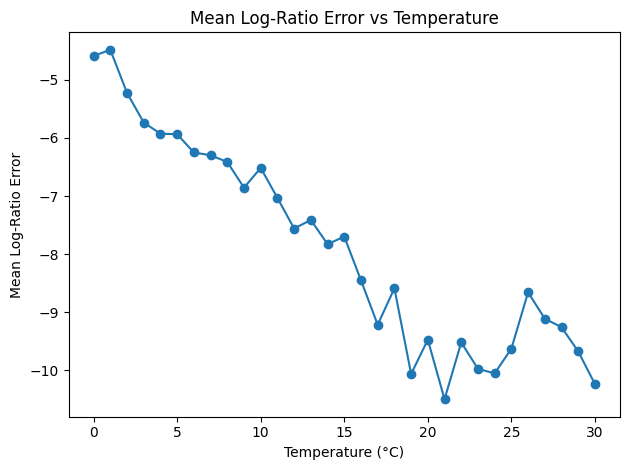

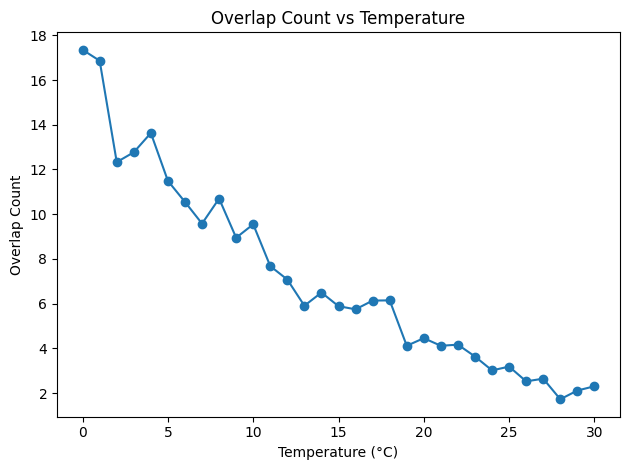

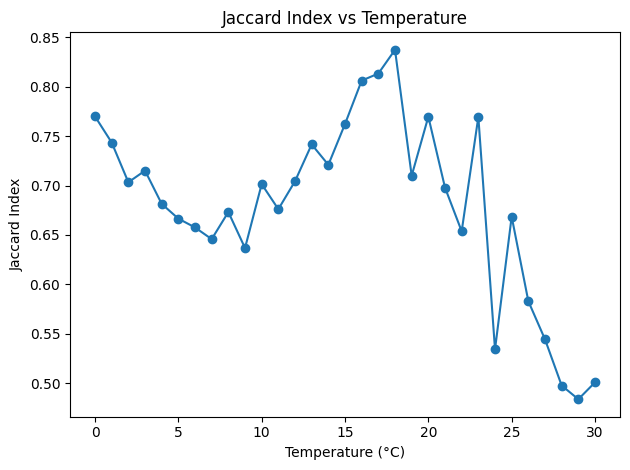

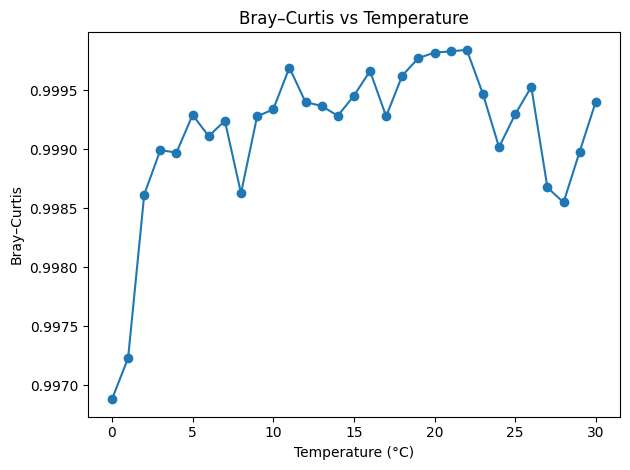

In [16]:
"""
test run with extracting data from the equilibrium file and plotting diversity / abundance
no Jacobian/Hermitian etc related stuff (those take extra computation)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Helper functions assumed in scope:
# err_eq_and_overlap, jaccard_index, shannon,
# bray_curtis_dissimilarity, eff_LV_params,
# eff_LV_jac, MiCRM_jac, leading_eigenvalue,
# leading_hermitian_eigenvalue, timescale_separation_full,
# compute_hessian_norm_nb

# 1) Load augmented equilibrium data
df = pd.read_csv('output/raw_eq_70_withR.csv')

# 2) Compute metrics for each row
records = []
for idx, row in df.iterrows():
    rep = row['replicate']
    T_C = row['T_C']
    # extract equilibria
    Cmi = row.filter(like='Cmi_').values.astype(float)
    Clv = row.filter(like='Clv_').values.astype(float)
    Rmi = row.filter(like='Rmi_').values.astype(float)

    # abundance error and overlap
    ErrEqAb, overlap = err_eq_and_overlap(Clv, Cmi)
    jacc = jaccard_index(Clv, Cmi, thresh=1e-6)
    sh_mi = shannon(Cmi)
    sh_lv = shannon(Clv)
    bc = bray_curtis_dissimilarity(Clv, Cmi)

    # reconstruct pT & Jacobians
    # (assumes structural and temp_trait can be called here)
    T_K = T_C + 273.15
    temp_p, _, _, _ = temp_trait(len(Cmi), {'T': T_K, 'Tr': 283.15, 'Ed': 3.5, 'rho_t': np.array([0,0]), 'L': np.full(len(Cmi),0.3)})
    # you need structural for each replicate; assuming generate_params with fixed seed per rep
    structural = generate_params(len(Cmi), len(Rmi), f_u=def_u, f_m=def_m, f_rho=def_rho,
                                 f_omega=def_omega, f_l=def_l, L=np.full(len(Cmi),0.3),
                                 T=273.15, rho_t=np.array([0,0]), Tr=283.15, Ed=3.5)
    pT = { **structural,
          'u': structural['u'] * temp_p[:,0][:,None],
          'm': temp_p[:,1],
          'lambda': structural['l'].sum(axis=2),
          'T': T_K }



    records.append({
        'replicate': rep, 'T_C': T_C,
        'ErrEqAb': ErrEqAb, 'overlap': overlap,
        'jaccard': jacc, 'shannon_mi': sh_mi, 'shannon_lv': sh_lv, 'bray_curtis': bc
    })

df_met = pd.DataFrame(records)

# 3) Compute mean across replicates for each T_C
df_mean = df_met.groupby('T_C').mean().reset_index()

# 4) Plot mean metrics vs temperature
metrics_to_plot = [
    ('ErrEqAb', 'Mean Log-Ratio Error'),
    ('overlap', 'Overlap Count'),
    ('jaccard', 'Jaccard Index'),
    ('bray_curtis', 'Bray–Curtis')
]

temps = df_mean['T_C']
for col, ylabel in metrics_to_plot:
    plt.figure()
    plt.plot(temps, df_mean[col], marker='o', label=ylabel)
    plt.xlabel('Temperature (°C)')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} vs Temperature')
    plt.tight_layout()
    plt.show()



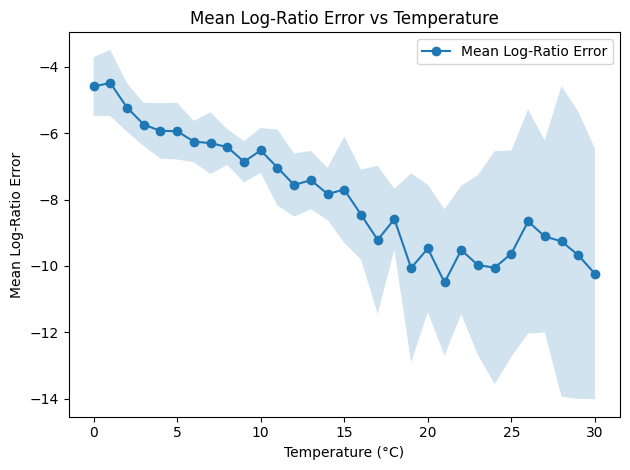

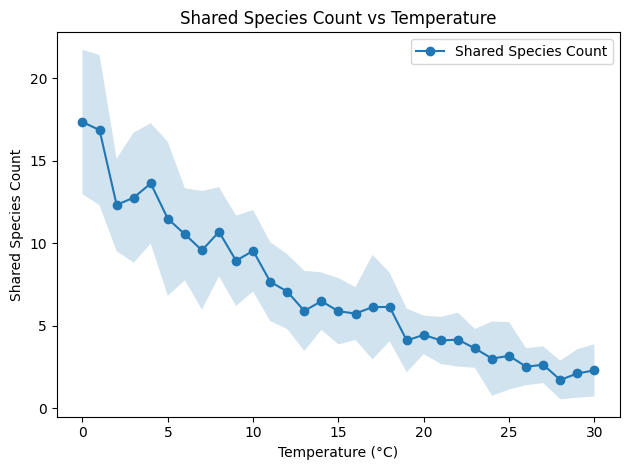

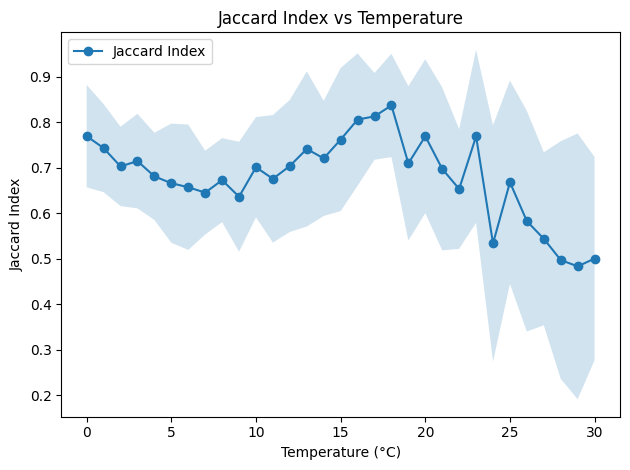

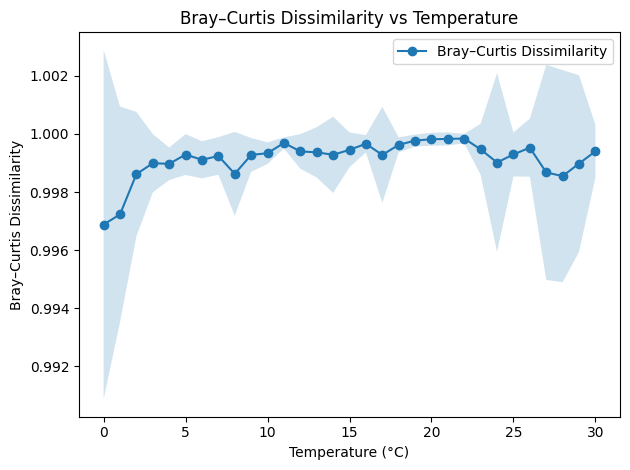

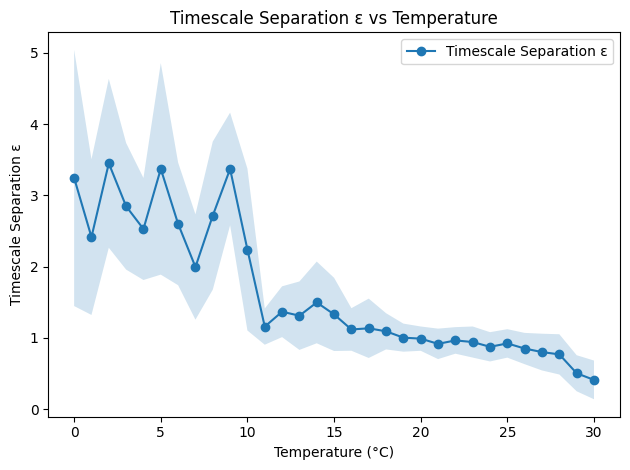

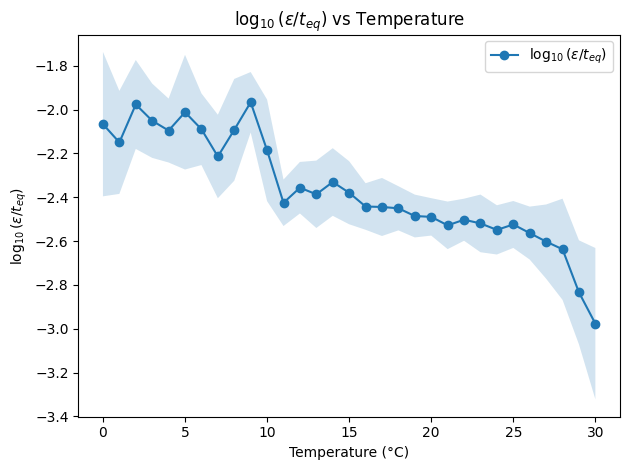

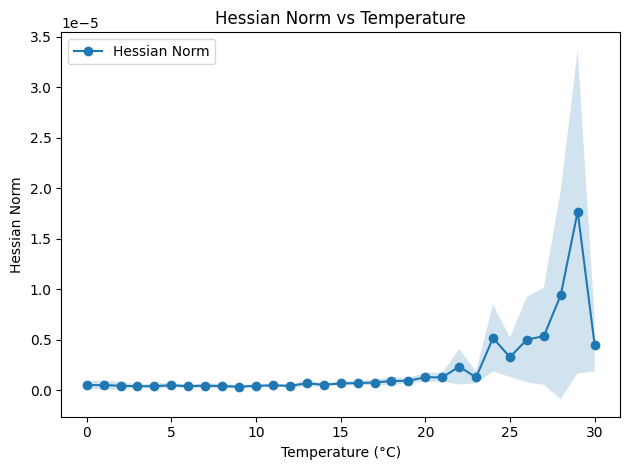

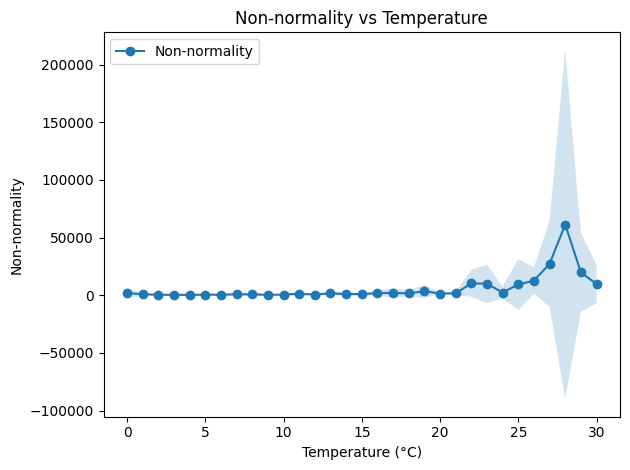

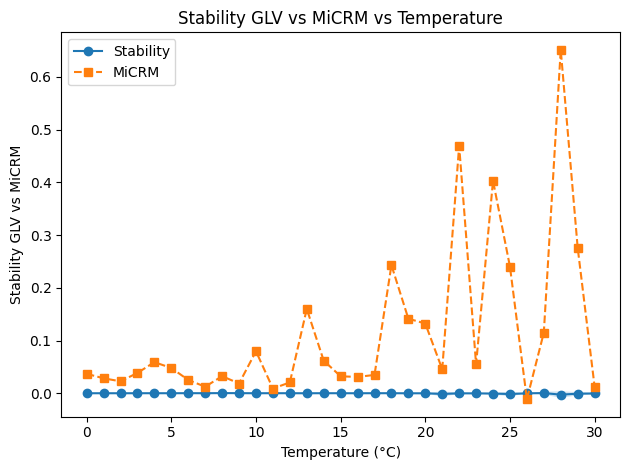

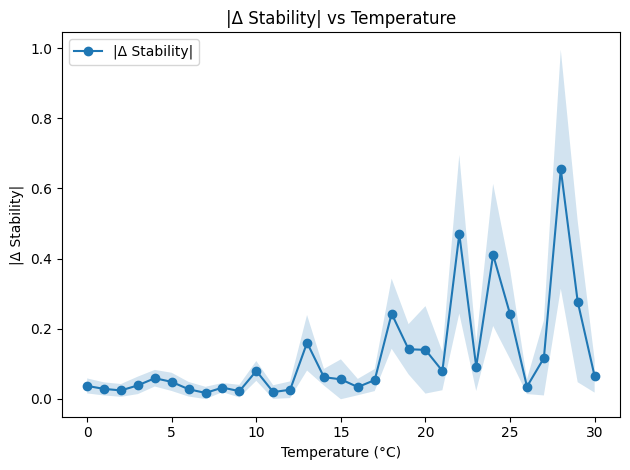

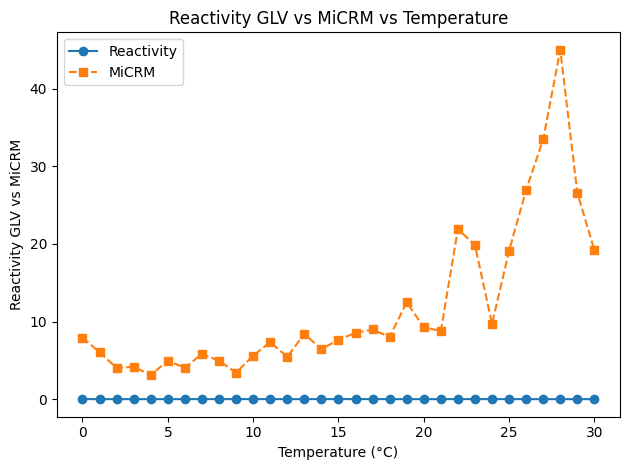

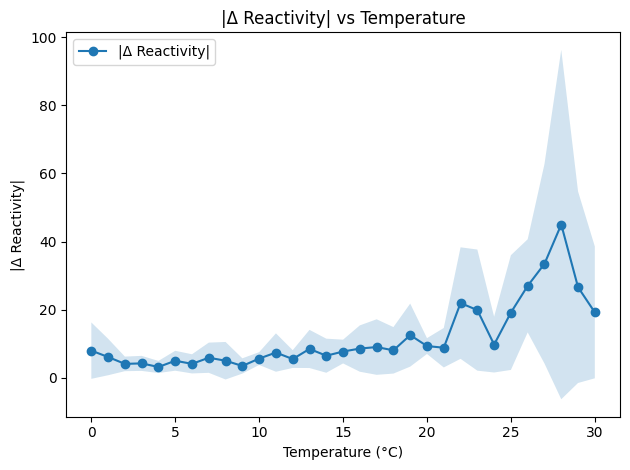

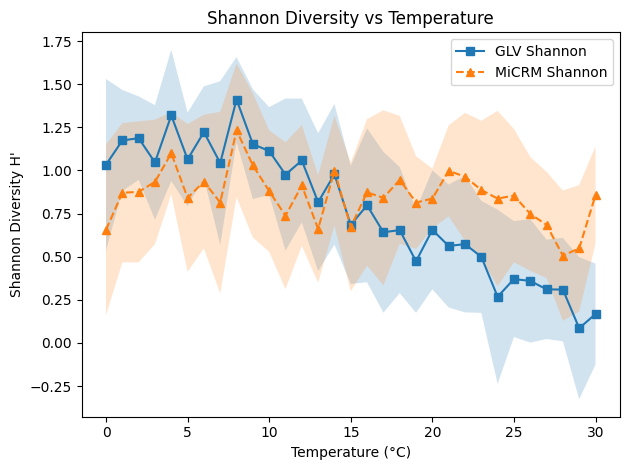

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load
df = pd.read_csv('metrics_70.csv')

# 2) Robustly coerce to float via complex()
numeric_cols = [
    'ErrEqAb','overlap','jaccard','shannon_mi','shannon_lv','bray_curtis',
    'stab_glv','stab_mi','abs_stab_err',
    'react_glv','react_mi','abs_react_err',
    'tau_C','tau_R','epsilon','t_eq','log10_eps_t_eq',
    'hessian_norm','non_normality'
]

for col in numeric_cols:
    df[col] = df[col].apply(lambda v: float(complex(v).real)).astype(float)

# 3) Group & summarize
grouped = df.groupby('T_C')
mean = grouped[numeric_cols].mean().reset_index()
std  = grouped[numeric_cols].std().reset_index()
temps = mean['T_C']

def plot_metric(col, ylabel, two_series=False, other_col=None):
    plt.figure()
    if two_series:
        plt.plot(temps, mean[col], 'o-', label=ylabel.split()[0])
        plt.plot(temps, mean[other_col], 's--', label=ylabel.split()[-1])
    else:
        plt.plot(temps, mean[col], 'o-', label=ylabel)
    plt.fill_between(temps,
                     mean[col]-std[col],
                     mean[col]+std[col],
                     alpha=0.2)
    plt.xlabel("Temperature (°C)")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs Temperature")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 4) Single‐series
plot_metric('ErrEqAb',      "Mean Log-Ratio Error")
plot_metric('overlap',      "Shared Species Count")
plot_metric('jaccard',      "Jaccard Index")
plot_metric('bray_curtis',  "Bray–Curtis Dissimilarity")
plot_metric('epsilon',      "Timescale Separation ε")
plot_metric('log10_eps_t_eq', r"$\log_{10}(\varepsilon / t_{eq})$")
plot_metric('hessian_norm', "Hessian Norm")
plot_metric('non_normality',"Non-normality")

# 5) Paired metrics
plot_metric('stab_glv', "Stability GLV vs MiCRM", two_series=True, other_col='stab_mi')
plot_metric('abs_stab_err', "|Δ Stability|")
plot_metric('react_glv', "Reactivity GLV vs MiCRM", two_series=True, other_col='react_mi')
plot_metric('abs_react_err', "|Δ Reactivity|")

# 6) Shannon
plt.figure()
plt.plot(temps, mean['shannon_lv'], 's-', label='GLV Shannon')
plt.plot(temps, mean['shannon_mi'], '^--', label='MiCRM Shannon')
plt.fill_between(temps,
                 mean['shannon_lv']-std['shannon_lv'],
                 mean['shannon_lv']+std['shannon_lv'], alpha=0.2)
plt.fill_between(temps,
                 mean['shannon_mi']-std['shannon_mi'],
                 mean['shannon_mi']+std['shannon_mi'], alpha=0.2)
plt.xlabel("Temperature (°C)")
plt.ylabel("Shannon Diversity H'")
plt.title("Shannon Diversity vs Temperature")
plt.legend()
plt.tight_layout()
plt.show()


the problem right now is that the teq values are all at 300 (need to sort out the estimate_teq part properly)